## 0. 导入相关库和声明相关变量

In [1]:
import torchvision
import torch

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## 1. 数据准备阶段

In [3]:
transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

In [4]:
train_dataset = torchvision.datasets.MNIST('.', train=True, transform=transform,
                                          download=True)

In [5]:
test_dataset = torchvision.datasets.MNIST('.', train=False, transform=transform,
                                         download=True)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size_train,
                                               shuffle=True, 
                                               num_workers=2,
                                               pin_memory=True,
                                               drop_last=True
                                           
                                            )

In [7]:
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=16,
                                               shuffle=False, 
                                               num_workers=2,
                                               pin_memory=True,
                                               drop_last=False
                                            )

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [9]:
example_data.shape, example_targets.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [10]:
example_data.dtype, example_targets.dtype

(torch.float32, torch.int64)

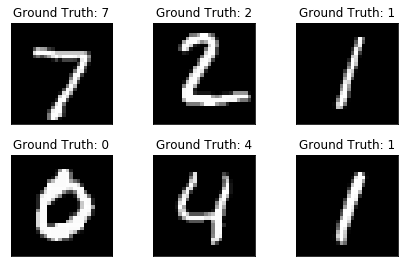

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

## 2. 建造简单的模型
- 继承 nn.Module
- 重写__init__和forward方法
    - __init__: 初始网络的操作层
    - forward: 构建网络的执行流程


In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [14]:
X = torch.randn((16, 1, 28, 28))

In [15]:
network = Net()

In [16]:
output = network(X)

/home/customer/miniconda3/envs/wyx/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
output.shape, output.dtype

(torch.Size([16, 10]), torch.float32)

In [18]:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

## 3. 训练模型

In [19]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [20]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'MNIST/model.pth')
            torch.save(optimizer.state_dict(), 'MNIST/optimizer.pth')

In [21]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [22]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/home/customer/miniconda3/envs/wyx/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/customer/miniconda3/envs/wyx/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3035, Accuracy: 826/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325138
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.308784
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.324311
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.241108
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.228745
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.210102
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.147475
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.084332
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.123464
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.970910
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.894720
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.930924
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.673604
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.454027
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.472297
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.178300
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.372529
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.311019
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.064307
Train Epoch: 1 [12160/6

## 4. 评估模型的性能

Text(0, 0.5, 'negative log likelihood loss')

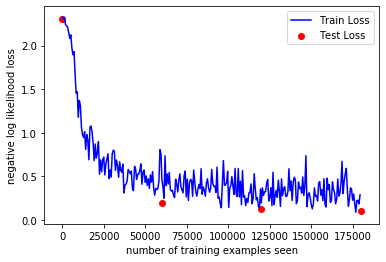

In [23]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

/home/customer/miniconda3/envs/wyx/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


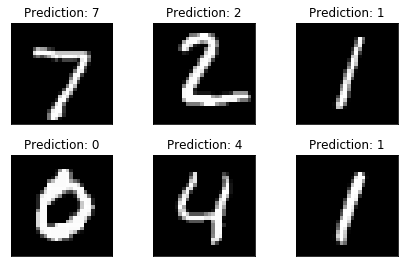

In [24]:
with torch.no_grad():
    output = network(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

## 5. 从Checkpoints继续训练


In [25]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)


In [26]:
network_state_dict = torch.load('MNIST/model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('MNIST/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [27]:
for i in range(4,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

/home/customer/miniconda3/envs/wyx/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.309863
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.226988
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.166347
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.295407
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.834621
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.299997
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.489031
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.398488
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.236804
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.279124
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.214127
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.486585
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.300694
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.388161
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.370815
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.229382
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.289838
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.184698
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.211417
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.486067
Train Epoch: 4 [12800/60000 (

Text(0, 0.5, 'negative log likelihood loss')

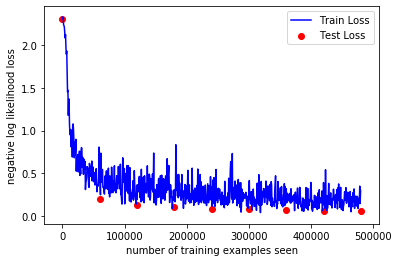

In [28]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')